In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
from shapely.geometry import mapping
import numpy as np
import numpy.ma as ma
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [2]:
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

In [3]:
fire_bndry_pth = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_bndry = gpd.read_file(fire_bndry_pth)

In [4]:
lndst_pst_fire_pth = os.path.join("cold-springs-fire",
                                      "landsat_collect",
                                      "LC080340322016070701T1-SC20180214145604",
                                      "crop",
                                      "*band*.tif")

In [5]:
lndst_pst_bnds = sorted(glob(os.path.join(lndst_pst_fire_pth)))

In [6]:
def open_clean_bnd(bnd_pth):
    return rxr.open_rasterio(bnd_pth, masked=True).squeeze()

In [7]:
lndst_pst_xr = open_clean_bnd(lndst_pst_bnds[0])

In [8]:
lndst_crs = es.crs_check(lndst_pst_bnds[0])

print("Landsat crs is:", lndst_crs)
print("Fire boundry crs", fire_bndry.crs)

Landsat crs is: EPSG:32613
Fire boundry crs EPSG:4269


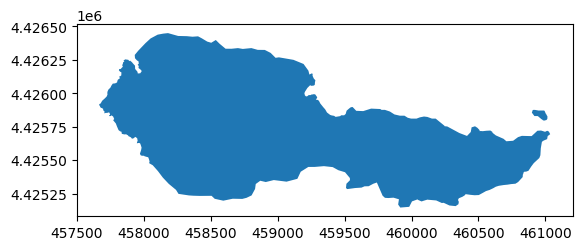

In [9]:
fire_bndry_utmz13 = fire_bndry.to_crs(lndst_crs)

fire_bndry_utmz13.plot()
plt.show()

In [10]:
def open_clean_band(band_path, crop_layer=None):
    if crop_layer is not None:
        try:
            clip_bound = crop_layer.geometry
            cleaned_band = rxr.open_rasterio(band_path,
                                             masked=True).rio.clip(clip_bound,
                                                                   from_disk=True).squeeze()
        except Exception as err:
            print("Oops, I need a geodataframe object for this to work.")
            print(err)
    else:
        cleaned_band = rxr.open_rasterio(band_path,
                                         masked=True).squeeze()
    return cleaned_band

def process_bands(paths, crop_layer=None, stack=False):
    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands

In [11]:
cleaned_bnds= process_bands(lndst_pst_bnds, fire_bndry_utmz13,stack=True)

I'm stacking your data now.


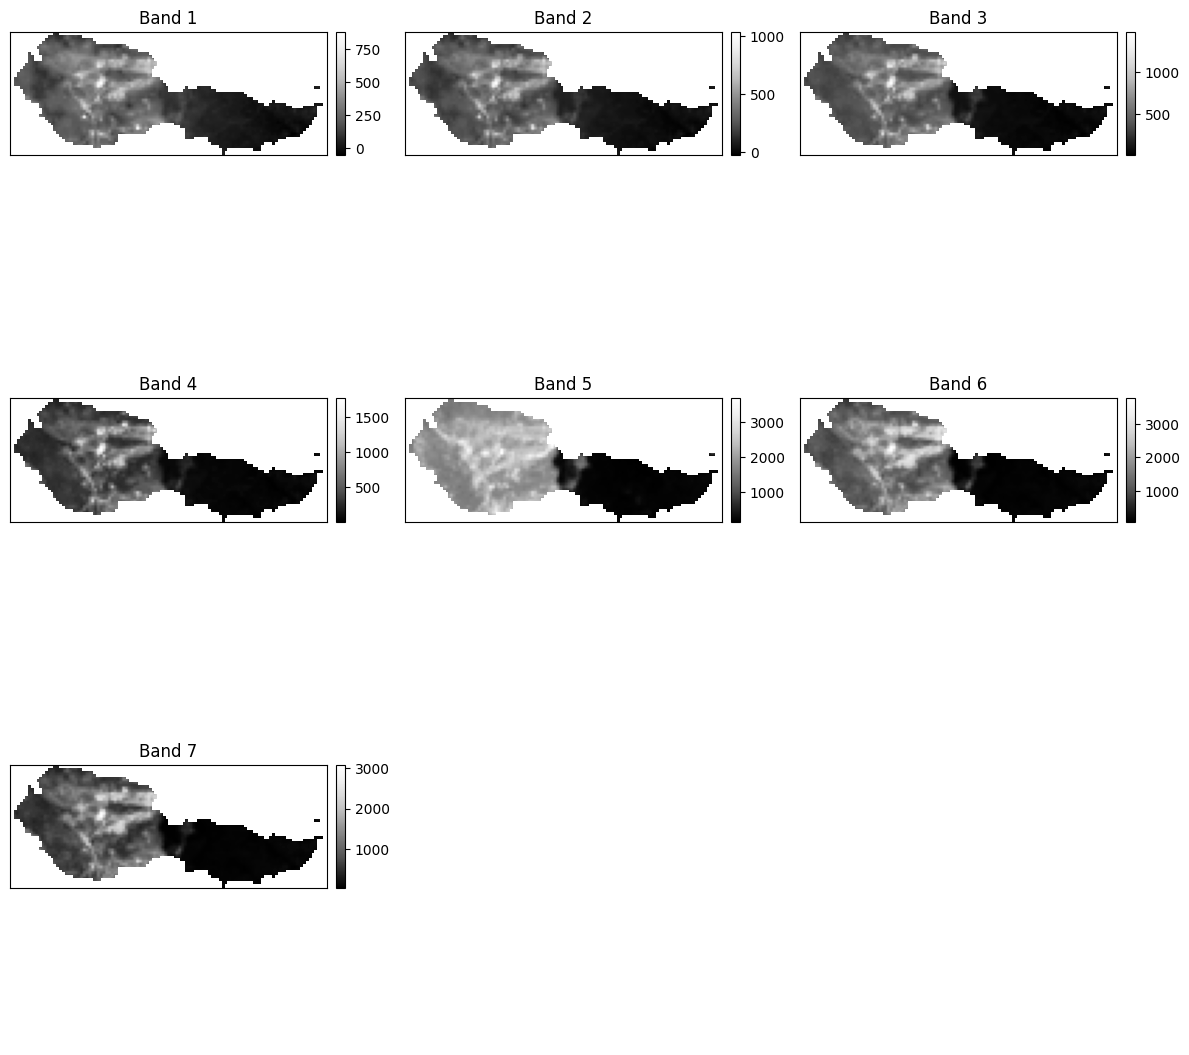

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [12]:
ep.plot_bands(cleaned_bnds)

/home/codespace/.python/current/lib/python3.10/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


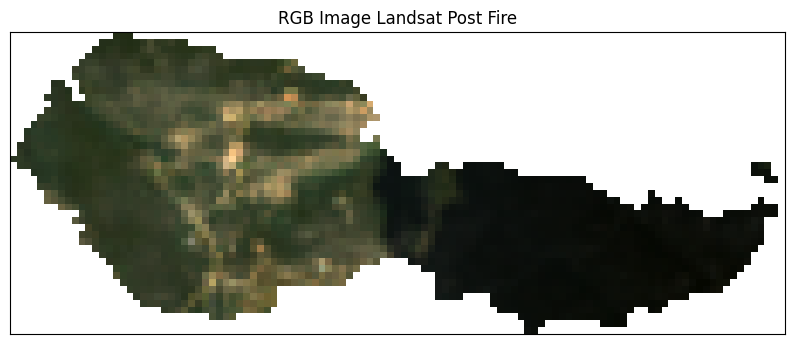

/home/codespace/.python/current/lib/python3.10/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


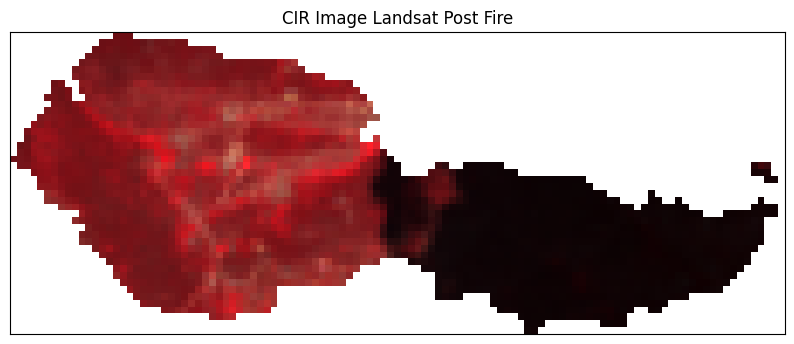

In [13]:
ep.plot_rgb(cleaned_bnds,
            rgb=[3, 2, 1],
            title="RGB Image Landsat Post Fire")

plt.show()

ep.plot_rgb(cleaned_bnds,
            rgb=[4, 3, 2],
            title="CIR Image Landsat Post Fire")

plt.show()